In this notebook, a Bragg resonator is designed with a higher kinetic inductance, by narrowing the widths of the conductor. The conductor widths are fixed, and the gap width is varied.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.constants as spc

import ResonatorOptimizer as ro

plt.style.use('seaborn-deep')

In [2]:
# Global Parameters
__er = 11.9
__fo = 9e09
__h = 500e-06
__t = 50e-09
__pen_depth = 39e-09
__total_width = 43.8e-06
__total_width_max = 43.8e-06
# __length = 8102.64e-06

__keyind = lambda X,X_array: min(enumerate(X_array), key=lambda x: abs(x[1]-X))

# Sweep geometry parameters to find figures of interest for different cpw widths and gaps

In [3]:
vp = spc.c / np.sqrt(__er)
__length = vp /  __fo 

In [4]:
# Instantiate parameter sweep object
ps = ro.ParamSweeps(__length,__total_width,__fo,__er,__h,__t,__pen_depth)

# Sweep geometry to see effect on parameters of interest
minw, maxw, wit = [2, (__total_width*1e06)-1, 0.01]
# minw, maxw, wit = [2, 8, 0.01]
sweep_params = ps.width_to_gap(minw,maxw,wit=wit)
# ps.plot_params(sweep_params)

In [5]:
def sweep_Lk(width,length,total_width_max):
    tw_sweep = np.arange(width+0.1e-06,__total_width_max,2e-06)

    Lk = []
    gap = []
    total_width = []

    for i in range(len(tw_sweep)):
        total_width.append(tw_sweep[i])
        minw, maxw, wit = [width*1e06, (total_width[i]*1e06), 0.1]
        params = ps.width_to_gap(minw,maxw,wit=wit)
        gap = .5*(total_width[i] - width)
        cpw = ro.cpwCalcs(width,gap,length,__fo, __er, h=__h, t=__t, pen_depth=__pen_depth)
        Lk.append(cpw.Lk())

    dic = {'Lk':Lk, 'tw_sweep':tw_sweep, 'gap':gap, 'total_width':total_width}
    df = pd.DataFrame(data=dic)
    return df

In [6]:
tw = 43.8e-06
cav_width = 10.00e-06
cav_gap = .5*(tw-cav_width)
cav_length = __length
cav_sweep = sweep_Lk(cav_width,cav_length,__total_width_max)

cav_width_sweep = cav_sweep.total_width.values
cav_gap_sweep = cav_sweep.gap.values
cav_Lk_sweep = cav_sweep.Lk.values

In [7]:
highZ_width = 2.50e-06
highZ_gap = .5*(tw-highZ_width)
highZ_length = cav_length/2
highZ_sweep = sweep_Lk(highZ_width,highZ_length,__total_width_max)

highZ_width_sweep = highZ_sweep.total_width.values
highZ_gap_sweep = highZ_sweep.gap.values
highZ_Lk_sweep = highZ_sweep.Lk.values

In [8]:
lowZ_width = 38.0e-06
lowZ_gap = .5*(tw-lowZ_width)
lowZ_length = cav_length/2
lowZ_sweep = sweep_Lk(lowZ_width,lowZ_length,__total_width_max)

lowZ_width_sweep = lowZ_sweep.total_width.values
lowZ_gap_sweep = lowZ_sweep.gap.values
lowZ_Lk_sweep = lowZ_sweep.Lk.values

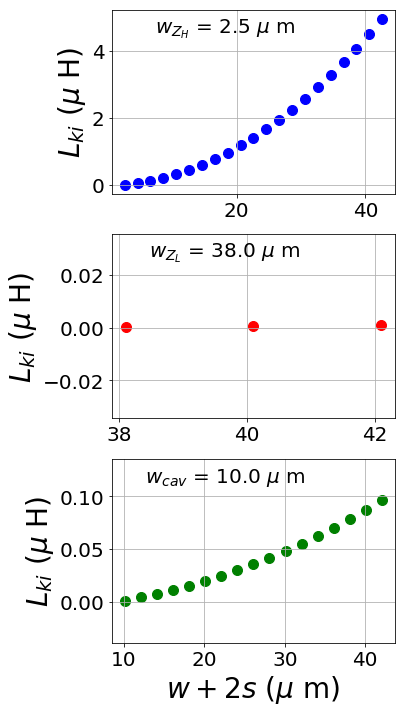

In [9]:
plt.figure(figsize=(10,10))
ax0 = plt.subplot(3,2,1)
ax0.scatter(highZ_width_sweep*1e06,np.array(highZ_Lk_sweep)*1e06,s=100,color='blue')
ax0.set_ylabel('$L_{ki}$ ($\mu$ H)')
ax0.text(.4,.9,'$w_{{Z_{{H}}}}$ = {} $\mu$ m'.format(highZ_width*1e06),fontsize=20,horizontalalignment='center',
         verticalalignment='center', transform=ax0.transAxes )
# plt.xlim(0,0.0001*1e06)
# plt.ylim(0,0.000008*1e06)
ax0.grid()

ax1 = plt.subplot(3,2,3)
ax1.scatter(lowZ_width_sweep*1e06,np.array(lowZ_Lk_sweep)*1e06,s=100,color='red')
ax1.set_ylabel('$L_{ki}$ ($\mu$ H)')
ax1.text(.4,.9,'$w_{{Z_{{L}}}}$ = {} $\mu$ m'.format(lowZ_width*1e06),fontsize=20,horizontalalignment='center',
         verticalalignment='center', transform=ax1.transAxes )
ax1.grid()

ax2 = plt.subplot(3,2,5)
ax2.scatter(cav_width_sweep*1e06,np.array(cav_Lk_sweep)*1e06,s=100,color='green')
ax2.set_xlabel('$w+2s$ ($\mu$ m)')
ax2.set_ylabel('$L_{ki}$ ($\mu$ H)')
ax2.text(.4,.9,'$w_{{cav}}$ = {} $\mu$ m'.format(cav_width*1e06),fontsize=20,horizontalalignment='center',
         verticalalignment='center', transform=ax2.transAxes )
ax2.grid()

# plt.subplot(2,2,2)
# plt.subplot(2,2,4)
plt.tight_layout()
plt.show()

# Design for specified kinetic inductance

In [10]:
# tw = 43.8e-06 # total width
tw = 40e-06 # total width

# Instantiate parameter sweep object
ps = ro.ParamSweeps(__length,tw,__fo,__er,__h,__t,__pen_depth)

# Sweep geometry to see effect on parameters of interest
minw, maxw, wit = [2, (tw*1e06)-1, 0.01]
sweep_params = ps.width_to_gap(minw,maxw,wit=wit)

# Retrieve width and gaps for desired Lki
Lki_target = 5.5419e-07
Lki_idx = np.abs(sweep_params.Lkl.values - Lki_target).argmin()

Lki = sweep_params.Lkl[Lki_idx]
Lt = sweep_params.Ltot[Lki_idx]
Cl = sweep_params.Cl[Lki_idx]
ws = sweep_params.width[Lki_idx]
gs = sweep_params.gap[Lki_idx]

In [11]:
def get_effective_length(width,gap,target_freq,elen='hw',lstrt=2000,lstop=8000,lit=20000):

    length = np.linspace(lstrt, lstop, lit)*1e-06
    f0 = []

    for l in range(len(length)):
        cpw = ro.cpwCalcs(width, gap, length[l], __fo, __er, h=__h, t=__t, pen_depth=__pen_depth)
        if elen == 'hw':
            f0.append(1 / (2 * length[l]* np.sqrt(cpw.capacitance_per_length() * cpw.Ltotal() ) ))
        elif elen =='qw':
            f0.append(1 / (4 * length[l]* np.sqrt(cpw.capacitance_per_length() * cpw.Ltotal() ) ))
        else:
            raise ValueError('Electrical length not recognized. Choose either \'hw\' or \'qw\'')
    
    return length[np.abs(np.array(f0)*1e-09 - target_freq*1e-09).argmin()]

In [12]:
cav_width = 10.00e-06
cav_gap = .5*(tw-cav_width)

highZ_width = 2.50e-06
highZ_gap = .5*(tw-highZ_width)

lowZ_width = 38.0e-06
lowZ_gap = .5*(tw-lowZ_width)

In [34]:
cav_length = get_effective_length(cav_width,cav_gap,9.50e09,elen='hw')
lowZ_length = get_effective_length(lowZ_width,lowZ_gap,9.50e09,elen='qw')
highZ_length = get_effective_length(highZ_width,highZ_gap,9.50e09,elen='qw',lstrt=1,lstop=6001)

In [35]:
highZ_length

0.0012778638431921597

In [36]:
cavity = ro.cpwCalcs(cav_width, cav_gap, cav_length, __fo, __er, h=__h, t=__t, pen_depth=__pen_depth)
Zlow = ro.cpwCalcs(lowZ_width, lowZ_gap, lowZ_length, __fo, __er, h=__h, t=__t, pen_depth=__pen_depth)
Zhigh = ro.cpwCalcs(highZ_width, highZ_gap, highZ_length, __fo, __er, h=__h, t=__t, pen_depth=__pen_depth)

In [39]:
freq = np.linspace(0,20,100000)*1e09
freq_nb = np.linspace(9.4,9.6,1000)*1e09

# Instantiate bragg class
br = ro.Bragg(__fo,__er,__h,__t,__pen_depth,no_mirrors=1)

# Specify bragg sections
bragg = br.bragg_resonator(freq,Zlow, Zhigh, cavity)
bragg_nb = br.bragg_resonator(freq_nb,Zlow, Zhigh, cavity)

rofit = ro.ResonatorFitting()
fit = rofit.LorentzianFit(freq_nb,bragg_nb,plot=False)
Q = fit.Q.values[0]
f0 = fit.centre.values[0]*1e06
fwhm = fit.out.values[0].params['fwhm'].value*1e-06

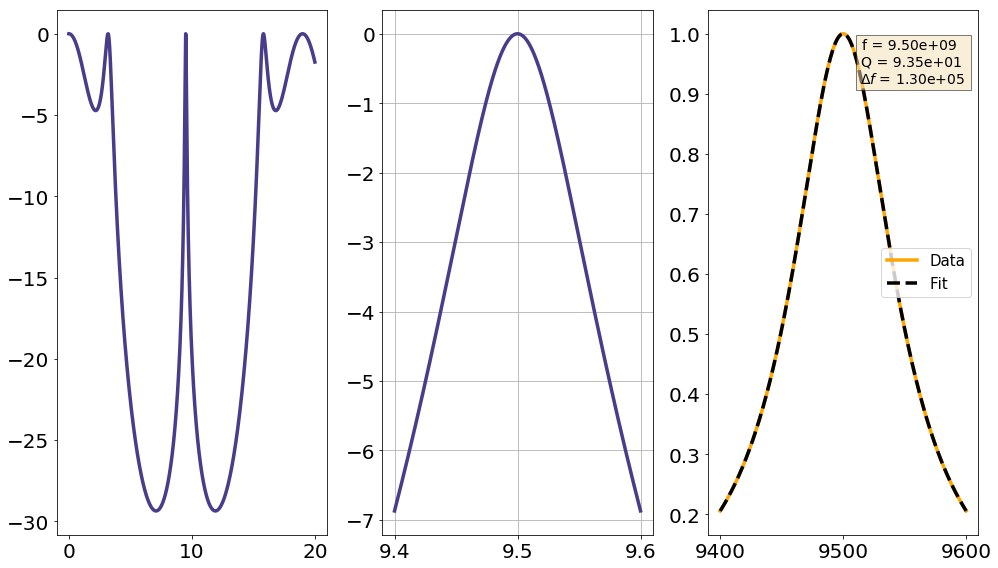

In [40]:
fig = plt.figure(figsize=(14,8))

ax0 = fig.add_subplot(131)
plt.plot(freq*1e-09,bragg,color = 'darkslateblue')

ax1 = fig.add_subplot(132)
plt.plot(freq_nb*1e-09,bragg_nb,color = 'darkslateblue')
plt.grid()

ax2 = fig.add_subplot(133)
plt.plot(fit.x,fit.y,color = 'orange', label = 'Data')
plt.plot(fit.x,fit.fit,'--',color = 'k',label = 'Fit')
plt.text(0.76, 0.9, 'f = {:.2e}  \nQ = {:.2e} \n$\Delta f$ = {:.2e} '.format(f0,Q,fwhm), horizontalalignment='center',
     verticalalignment='center', transform=ax2.transAxes,fontsize=14,bbox=dict(facecolor='wheat', alpha=0.5))
plt.legend(loc='center right')

plt.tight_layout()
plt.show()

In [28]:
rofit.fit_3dB(freq_nb,bragg_nb)

,Q,center,fwhm
0,45.544589,9.099800e+09,1.997998e+08


In [41]:
rq = ro.ResonatorQuality(freq_nb,bragg_nb,alpha=cavity.alpha())
rq.Qloaded()

64.31567711811445

In [42]:
rq.Qint()

3709455058666.8633

In [43]:
rq.Qloaded()

64.31567711811445

In [44]:
rq = ro.ResonatorQuality(freq_nb,bragg_nb)
rq.Qloaded()

64.31567711811445

In [45]:
rq.insertion_loss()

ZeroDivisionError: float division by zero

In [46]:
print('wcav = {:.2f} um'.format(cav_width*1e06))
print('gcav = {:.2f} um'.format(cav_gap*1e06))
print('lcav = {:.4f} um'.format(cav_length*1e06))

wcav = 10.00 um
gcav = 16.90 um
lcav = 6055.6028 um


In [47]:
print('wlow = {:.2f} um'.format(lowZ_width*1e06))
print('glow = {:.2f} um'.format(lowZ_gap*1e06))
print('llow = {:.4f} um'.format(lowZ_length*1e06))

wlow = 38.00 um
glow = 2.90 um
llow = 3271.1636 um


In [59]:
print('whigh = {:.2f} um'.format(highZ_width*1e06))
print('ghigh = {:.2f} um'.format(highZ_gap*1e06))
print('lhigh = {:.4f} um'.format(highZ_length*1e06))

whigh = 2.50 um
ghigh = 20.65 um
lhigh = 1261.9630 um


In [16]:
cavity.alpha()

4.234574356480877e-10

In [18]:
rq = ro.ResonatorQuality(freq_nb,bragg_nb,alpha=cavity.alpha())
rq.Qloaded()

1716572.7404396434

In [21]:
rq.Qint()

3709455058666.8633

In [23]:
rq.insertion_loss(format='db')

4.019448838600808e-06

In [25]:
rq.Qloaded()

1716572.7404396434

In [26]:
rq.Qext()

1716573.5347944181

In [101]:
x = [-6796, 8160, 8091, -6873]
y = [7842, 7757, -7205, -7127]

In [105]:
sum(x) / len(x)

645.5

In [106]:
sum(y) / len(y)

316.75